# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'
dirSumma = dirProj + 'summa/ModTsfc_summa/output/'

## Functions to quickly evaluate all model output

In [3]:
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
CDP = xr.open_dataset('CDP.ModTsfc.nc')

## Model output

In [20]:
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}
CDP = CDP.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDP_daily = CDP.resample(how='mean', freq='d', dim='time')

SWA = SWA.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWA_daily = SWA.resample(how='mean', freq='d', dim='time')

### Define control lists etc

In [5]:
# ----------
# Experiment names and identifiers
experiments = ['intBias_thermalCond', 'intBias_stability']

# Layer
expNames = {'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']}

# Thermal conductivity
expNames['thermalCond'] = ['tyen1965', 'smnv2000_Low', 'smnv2000_Mid', 'smnv2000_High']

# Stability
expNames['stability'] = ['standard_Low', 'standard_High', 'mahrtexp_Low', 'mahrtexp_High']

# Make experiment names list
expID_dict = {}
for exp in experiments:
    expID_dict[exp] = []

    if 'stability' in exp:
        for layer in expNames['layers']:
            for stab in expNames['stability']:
                # Name for identifying files for this experiment
                expID = layer + '_' + stab
                expID_dict[exp].append(expID)

    elif 'thermalCond' in exp:
        for layer in expNames['layers']:
            for thCond in expNames['thermalCond']:
                # Name for identifying files for this experiment
                expID = layer + '_' + thCond
                expID_dict[exp].append(expID)

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

In [39]:
# Put all results in a single dictionary
from pathlib import Path

resultsDict = {}
for sN in siteNames:
    if sN == 'CDP':
        continue
    print('')
    print(sN)
    print('')  
    for exp in experiments:
        print('')
        print(exp)
        print('')        
        os.chdir(dirSumma + exp + '/' + sN)
        for names in expID_dict[exp]:
            for year in siteYears[sN]:
                wy = str(year) + '-' + str(year + 1) 
                fileName = names + '_' + wy + '_' + names + '_1.nc'
                temp = Path(fileName)
                
#                 if temp.exists():
#                     print(fileName + ' exists')
#                 else:
#                     print(fileName + ' DOES NOT EXIST')
                try:
                    temp = xr.open_dataset(fileName, autoclose=True)
                    resultsDict[names + 'wy' + str(year + 1)] = temp
    
                except OSError:
                    print(fileName + ' was not found. Skipping...')
                
    resultsDataSet = xr.Dataset()
    tempDict = {}
    for expNum, exp in enumerate(experiments):
        for nameNum, names in enumerate(expID_dict[exp]):
            tempDataSet = xr.Dataset()
            for k in scalar_data_vars:
                if not 'scalar' in k:
                    continue

                # Assign scalar value to a dataArray
                try:
                    darray = xr.concat([resultsDict[scen][k] for scen in sorted(resultsDict)
                                        if names + 'wy' in scen], dim='time')
                    # Remove hru dimension, as it is unused
                    darray = darray.squeeze('hru')
                    darray = darray.drop('hru')
                    tempDataSet[k] = darray
                except ValueError:
                    print('Could not find ' + names)
            # Assign to a temporary dictionary for each experiment name
            tempDataSet.coords['exp'] = exp
            tempDataSet.coords['layer'] = names.split('_')[0]
            tempDataSet.coords['family'] = '_'.join(names.split('_')[-2:])
            tempDict[names] = tempDataSet

    resultsDataSet = xr.concat([tempDict[scen] for exp in experiments for scen in expID_dict[exp]], dim='expID')
    resultsDataSet.coords['expID'] = list([n for exp in experiments for n in expID_dict[exp] ])

    # Recreate time series since summa's time format does not play well with datetime
    resultsDataSet['time'] = pd.date_range(d1[sN], d2[sN], freq='H')

    os.chdir(dirData + '/summaResults')
    resultsDataSet.to_netcdf(sN + '.summaResults.intBias.nc')



SWA


intBias_thermalCond


intBias_stability



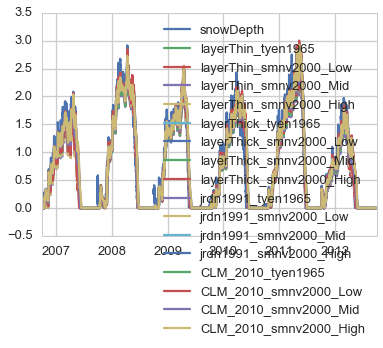

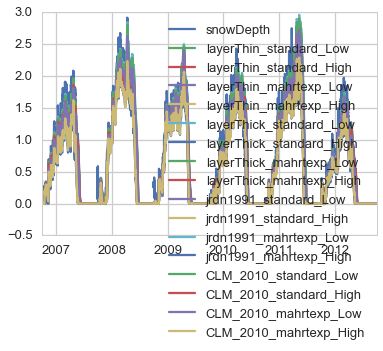

In [25]:
for expNum, exp in enumerate(experiments):
    plt.figure()
    plt.plot(SWA.time, SWA.snowDepth)

    for nameNum, names in enumerate(expID_dict[exp]):
        plt.plot(resultsDataSet.time, resultsDataSet.sel(expID=names).scalarSnowDepth, label=names)
    plt.legend()

In [41]:
print(resultsDataSet)

<xarray.Dataset>
Dimensions:                (expID: 32, time: 52608)
Coordinates:
  * time                   (time) datetime64[ns] 2006-10-01 ...
    exp                    (expID) <U19 'intBias_thermalCond' ...
    layer                  (expID) <U10 'layerThin' 'layerThin' 'layerThin' ...
    family                 (expID) <U19 'layerThin_tyen1965' 'smnv2000_Low' ...
  * expID                  (expID) <U24 'layerThin_tyen1965' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.749e-07 0.0 0.0 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.272e-12 0.0 0.0 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.2 281.0 279.8 278.9 ...
    scalarSenHeatTotal     (expID, time) float64 -82.07 -27.32 -20.47 -15.7